In [1]:
!pip install kaggle
!mkdir .kaggle
!cp ../kaggle.json ~/.kaggle/kaggle.json
!kaggle datasets download -d thedevastator/imdb-large-movie-review-dataset-binary-sentiment
!unzip imdb-large-movie-review-dataset-binary-sentiment.zip

mkdir: .kaggle: File exists
imdb-large-movie-review-dataset-binary-sentiment.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  imdb-large-movie-review-dataset-binary-sentiment.zip
  inflating: test.csv                
  inflating: train.csv               
  inflating: unsupervised.csv        


In [2]:
!pip install seaborn  pandarallel ipywidgets yellowbrick textblob 

In [49]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from textblob import TextBlob
from textblob.sentiments import NaiveBayesAnalyzer
import seaborn as sns
import ipywidgets as widgets
from pandarallel import pandarallel
from textblob import Blobber
from yellowbrick.cluster import KElbowVisualizer
import nltk
nltk.download('movie_reviews')
nltk.download('punkt')

pandarallel.initialize(progress_bar=True)
pd.set_option('display.float_format', lambda x: '%.5f' % x)




The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
INFO: Pandarallel will run on 4 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/a.okoh/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
[nltk_data] Downloading package punkt to /Users/a.okoh/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
data = pd.read_csv('data/train.csv')
data.head()

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    25000 non-null  object
 1   label   25000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 390.8+ KB


In [6]:
data['label'].value_counts()

0    12500
1    12500
Name: label, dtype: int64

In [7]:
tb = Blobber(analyzer=NaiveBayesAnalyzer())
def get_sentiments(text):
    # score =  TextBlob(text,analyzer=NaiveBayesAnalyzer()).sentiment
    score = tb(text).sentiment
    verdict = score[0]
    pos_score = score[1]
    neg_score = score[2]
    return verdict, pos_score, neg_score

In [9]:
data[["verdict", 'pos_score', 'neg_score']] = data.parallel_apply(lambda x: get_sentiments(x.text), axis=1, result_type="expand")
# data["pos_score"] = data.parallel_apply(lambda x: get_sentiments(x.text, 1), axis=1)
# data["neg_score"] = data.parallel_apply(lambda x: get_sentiments(x.text, 2), axis=1)
data.head()

,text,label,verdict,pos_score,neg_score
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,pos,1.000000,3.020684e-12
1,"""I Am Curious: Yellow"" is a risible and preten...",0,neg,0.343421,6.565792e-01
2,If only to avoid making this type of film in t...,0,neg,0.429163,5.708371e-01
3,This film was probably inspired by Godard's Ma...,0,pos,0.921490,7.850973e-02
4,"Oh, brother...after hearing about this ridicul...",0,neg,0.056067,9.439326e-01


In [70]:
data[(data['verdict']=='pos') & (data['clusters']==3)]

,text,label,verdict,pos_score,neg_score,clusters
36,"I rented this movie about 3 years ago, and it ...",0,pos,0.599838,0.400162,3
58,"I thought this was a very clunky, uninvolving ...",0,pos,0.550153,0.449847,3
59,Ned aKelly is such an important story to Austr...,0,pos,0.608810,0.391190,3
67,I like Goldie Hawn and wanted another one of h...,0,pos,0.545593,0.454407,3
123,This fanciful horror flick has Vincent Price p...,0,pos,0.622064,0.377936,3
...,...,...,...,...,...,...
24779,"""A Guy Thing"" may not be a classic, but it sur...",1,pos,0.635205,0.364795,3
24924,This movie was very good. If you are one who l...,1,pos,0.543141,0.456859,3
24929,"Well, this film is a difficult one really. To ...",1,pos,0.634655,0.365345,3
24961,"magellan33 said: ""You can only do so much when...",1,pos,0.586928,0.413072,3


In [73]:
data[data['clusters']==3]['pos_score'].value_counts().sort_index()

0.379061    1
0.379273    1
0.379513    1
0.380040    1
0.380451    1
           ..
0.650758    1
0.650943    1
0.651006    1
0.651614    1
0.651686    1
Name: pos_score, Length: 1108, dtype: int64

In [74]:
data[data['clusters']==2]['pos_score'].value_counts().sort_index()

0.889909       1
0.890025       1
0.890123       1
0.890295       1
0.890408       1
            ... 
1.000000      53
1.000000       5
1.000000      88
1.000000      12
1.000000    1502
Name: pos_score, Length: 13341, dtype: int64

In [10]:
data['verdict'].value_counts()

pos    17728
neg     7272
Name: verdict, dtype: int64

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25000 entries, 0 to 24999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   text       25000 non-null  object 
 1   label      25000 non-null  int64  
 2   verdict    25000 non-null  object 
 3   pos_score  25000 non-null  float64
 4   neg_score  25000 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 976.7+ KB


<AxesSubplot: xlabel='pos_score', ylabel='neg_score'>

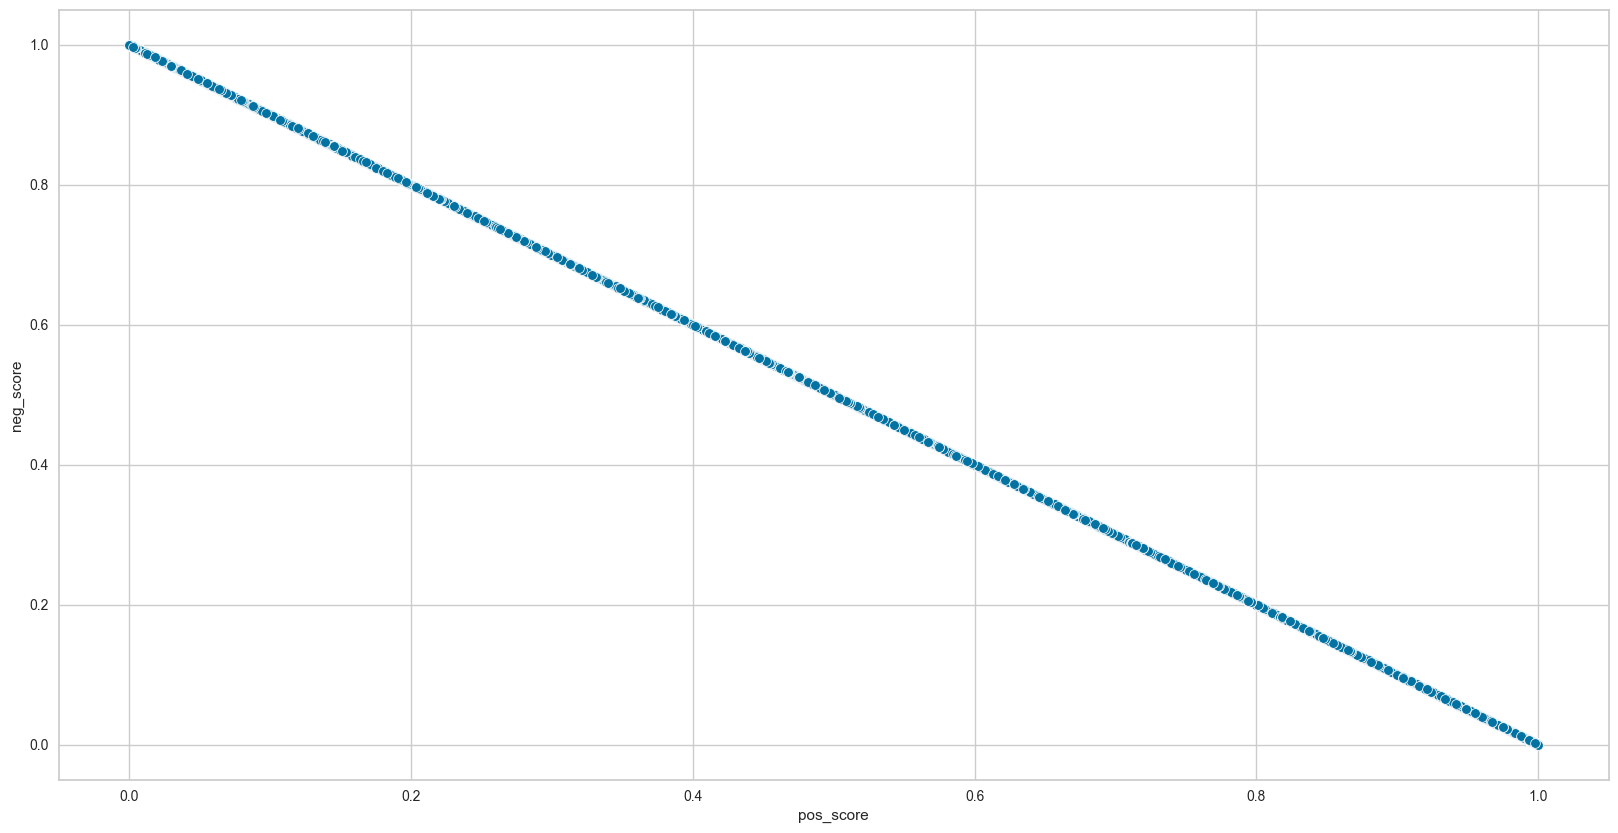

In [12]:
plt.figure(figsize=(20,10))
sns.scatterplot(data=data, x="pos_score", y="neg_score")

In [50]:
Xfeatures = data[['pos_score', "neg_score"]]
model = KMeans(n_clusters=5, init ="k-means++", random_state=42)
model.fit(Xfeatures)

/Users/a.okoh/opt/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=42)

In [14]:
pred = model.predict(Xfeatures)

In [15]:
data['clusters'] = pred
data.head()

,text,label,verdict,pos_score,neg_score,clusters
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,pos,1.000000,3.020684e-12,2
1,"""I Am Curious: Yellow"" is a risible and preten...",0,neg,0.343421,6.565792e-01,4
2,If only to avoid making this type of film in t...,0,neg,0.429163,5.708371e-01,3
3,This film was probably inspired by Godard's Ma...,0,pos,0.921490,7.850973e-02,2
4,"Oh, brother...after hearing about this ridicul...",0,neg,0.056067,9.439326e-01,1


In [16]:
data.head(30)

,text,label,verdict,pos_score,neg_score,clusters
0,I rented I AM CURIOUS-YELLOW from my video sto...,0,pos,1.000000e+00,3.020684e-12,2
1,"""I Am Curious: Yellow"" is a risible and preten...",0,neg,3.434208e-01,6.565792e-01,4
2,If only to avoid making this type of film in t...,0,neg,4.291629e-01,5.708371e-01,3
3,This film was probably inspired by Godard's Ma...,0,pos,9.214903e-01,7.850973e-02,2
4,"Oh, brother...after hearing about this ridicul...",0,neg,5.606739e-02,9.439326e-01,1
5,I would put this at the top of my list of film...,0,neg,7.881578e-03,9.921184e-01,1
6,Whoever wrote the screenplay for this movie ob...,0,pos,8.443613e-01,1.556387e-01,0
7,"When I first saw a glimpse of this movie, I qu...",0,pos,9.995160e-01,4.839792e-04,2
8,"Who are these ""They""- the actors? the filmmake...",0,pos,9.999997e-01,3.241790e-07,2
9,This is said to be a personal film for Peter B...,0,pos,9.805689e-01,1.943108e-02,2


/Users/a.okoh/opt/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/a.okoh/opt/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/a.okoh/opt/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/a.okoh/opt/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


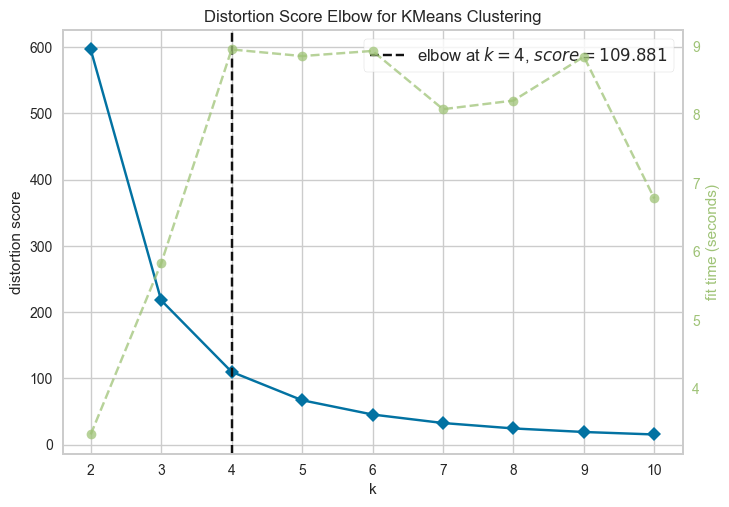

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [23]:
model = KElbowVisualizer(KMeans(random_state=42),  k=10)
model.fit(Xfeatures)
model.show()

/Users/a.okoh/opt/miniconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/a.okoh/opt/miniconda3/lib/python3.8/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


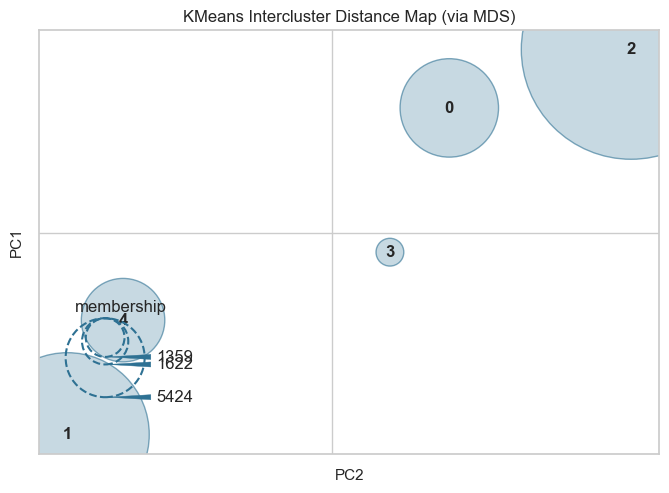

<AxesSubplot: title={'center': 'KMeans Intercluster Distance Map (via MDS)'}, xlabel='PC2', ylabel='PC1'>

In [52]:
from yellowbrick.cluster import InterclusterDistance
model = KMeans(5, init ="k-means++",random_state=42)
visualizer = InterclusterDistance(model)

visualizer.fit(Xfeatures)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [60]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([('kmeans', model)])

In [64]:
 from mlem.api import save
from datetime import datetime

def get_time_stamp():
    current_time = datetime.now()
    time_stamp = current_time.timestamp()
    date_time = datetime.fromtimestamp(time_stamp)
    return date_time.strftime("%d-%m-%Y-%H:%M:%S")

timestamp = get_time_stamp()

save(pipe,f"model/{timestamp}_kmeans",sample_data=Xfeatures,)

MlemModel(location=Location(path='/Users/a.okoh/Documents/year_highlight/model/22-12-2022-23:16:00_kmeans.mlem', project=None, rev=None, uri='file:///Users/a.okoh/Documents/year_highlight/model/22-12-2022-23:16:00_kmeans.mlem', project_uri=None, fs=<fsspec.implementations.local.LocalFileSystem object at 0x7fe3c9bf4310>), params={}, artifacts={'data': LocalArtifact(uri='22-12-2022-23:16:00_kmeans', size=100885, hash='aaf90d2272d0ab1107d247bf7f5baf21')}, requirements=Requirements(__root__=[InstallableRequirement(module='numpy', version='1.24.0', package_name=None, extra_index=None), InstallableRequirement(module='pandas', version='1.5.2', package_name=None, extra_index=None), InstallableRequirement(module='sklearn', version='1.2.0', package_name='scikit-learn', extra_index=None)]), processors_cache={'model': SklearnPipelineType(model=Pipeline(steps=[('kmeans', KMeans(n_clusters=5, random_state=42))]), io=SimplePickleIO(), methods={'predict': Signature(name='predict', args=[Argument(name=